In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import sys
import glob
import pandas as pd
import os
import seaborn as sns

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from collections import defaultdict
import pickle
import re
import json
from pathlib import Path
import scipy.stats
import time

from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_plotting_utils import *
from open_spiel.python.examples.ubc_sample_game_tree import sample_game_tree, flatten_trees, flatten_tree
from open_spiel.python.examples.ubc_clusters import projectPCA, fitGMM
from open_spiel.python.examples.ubc_utils import *
import open_spiel.python.examples.ubc_dispatch as dispatch

from auctions.webutils import *

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

from open_spiel.python.examples.ubc_cma import *

output_notebook()
from open_spiel.python.games.clock_auction_base import InformationPolicy, ActivityPolicy, UndersellPolicy, TiebreakingPolicy
from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_decorators import TakeSingleActionDecorator, TremblingAgentDecorator, ModalAgentDecorator

Loading BokehJS ...

In [22]:
# load runs from experiments
experiments = []
experiments += ['nov21_external_fixed_v4_no_other_heuristics']

runs = []
for experiment in experiments:
    runs += Experiment.objects.get(name=experiment).equilibriumsolverrun_set.all()
print(f"Found {len(runs)} runs")

Found 180 runs


# Analyze runs

In [23]:
records = []
for run in tqdm(runs):    
    game = run.game.load_as_spiel()
    record = {
        'run_name': run.name,
        'game_name': run.game.name, 
        'seed': run.config.get('seed'), 
        'config': run.get_config_name(),
        'alg': get_algorithm_from_run(run),
    }
    
    record.update(get_game_info(game, run.game))  
    
    record['no_error'] = False
    records.append(record) # Put it here so you see the False's in the display
        
    try:
        game, final_checkpoint, policy = get_results(run, load_policy=True)
    except Exception as e:
        print(f"Skipping run {run.name} because of error {e}")
        continue
    
    try:
        
        record['t'] = final_checkpoint.t
        record['walltime'] = run.walltime(),
        evaluation = final_checkpoint.get_modal_eval()
        # evaluation = final_checkpoint.get_old_eval()
        
        record['nash_conv'] = evaluation.nash_conv
        record['rewards'] = evaluation.mean_rewards
        record['nash_conv_frac'] = evaluation.nash_conv / sum(evaluation.mean_rewards) if not pd.isnull(evaluation.nash_conv) else np.nan
        record['heuristic_conv'] = evaluation.heuristic_conv
        record['heuristic_conv_frac'] = evaluation.heuristic_conv / sum(evaluation.mean_rewards) if not pd.isnull(evaluation.heuristic_conv) else np.nan

        for i in range(game.num_players()):
            record[f'rewards_{i}'] = evaluation.mean_rewards[i]
            record[f'nc_player_improvements_{i}'] = evaluation.nash_conv_player_improvements[i] if not pd.isnull(evaluation.nash_conv) else np.nan
            record[f'nc_player_improvements_frac_{i}'] = (evaluation.nash_conv_player_improvements[i] / evaluation.mean_rewards[i]) if not pd.isnull(evaluation.nash_conv) else np.nan

            record[f'hc_player_improvements_{i}'] = evaluation.heuristic_conv_player_improvements[i] if not pd.isnull(evaluation.heuristic_conv) else np.nan
            record[f'hc_player_improvements_frac_{i}'] = (evaluation.heuristic_conv_player_improvements[i] / evaluation.mean_rewards[i]) if not pd.isnull(evaluation.heuristic_conv) else np.nan

        record.update(**analyze_samples(evaluation.samples, game))

        nc = record['nash_conv']
        hc = record['heuristic_conv']
        # print(f"NashConv = {(np.nan if pd.isnull(nc) else nc):.2f}; HeuristicConv = {(np.nan if pd.isnull(hc) else hc):.2f}")
        # worked, nash_conv_runtime, res = time_bounded_run(300, nash_conv, game, policy, return_only_nash_conv=True, restrict_to_heuristics=True)
        # print(worked, nash_conv_runtime, res)

        
        record['no_error'] = True
    except Exception as e:
        print(f"Something wrong with {run}. Skipping. {e}")
        # raise e
        # break
        import traceback
        print(traceback.format_exc())

print(len(records))

100%|█████████████████████████████████████████| 180/180 [01:15<00:00,  2.38it/s]

180


In [24]:
df = pd.DataFrame.from_records(records)
with pd.option_context('display.max_rows', None):
    display(df.query('~no_error')[['value_structure', 'rule', 'base_game_name', 'no_error']].value_counts().sort_index())

Series([], Name: count, dtype: int64)

In [38]:
for i in range(len(df['unsold'].iloc[0])):
    df[f'unsold_{i}'] = np.round(df['unsold'].apply(lambda x: x[i]), 5)

In [39]:
np.round((df.query(f'~(hc_player_improvements_frac_0 < {good_thresh} and hc_player_improvements_frac_1 < {good_thresh})')[['base_game_name', 'rule']].value_counts().sort_index() / 30) * 100, 2)

base_game_name               rule             
oct04_encumberedheuristic_1  grace                 6.67
                             tie_break             3.33
                             undersell_allowed    13.33
oct04_encumberedheuristic_3  base                  6.67
                             grace                20.00
                             tie_break             3.33
                             undersell_allowed     6.67
oct04_encumberedheuristic_4  base                  3.33
                             grace                16.67
                             tie_break             6.67
Name: count, dtype: float64

In [40]:
palette = dict()
colors = ['red', 'blue', 'magenta', 'green', 'orange', 'brown', 'black', 'navy', 'pink', 'gold', 'darkgreen', 'orangered', 'olive']
# for i, v in enumerate(df['variant'].unique()):
#     palette[v] = colors[i]

In [41]:
# Need to a) Remove "bad" entries b) Be careful about comparisons that are missing datapoints 
df_plt = df.copy()

In [42]:
### Remove bad entries

# TODO: generalize to 3+ players

df_plt = df.copy()

good_thresh = 0.1
# good_thresh_abs = 5
# df_plt = df.query(f'player_improvements_0 < {good_thresh_abs} and player_improvements_1 < {good_thresh_abs}')
df_plt = df.query(f'hc_player_improvements_frac_0 < {good_thresh} and hc_player_improvements_frac_1 < {good_thresh}').copy()
# df_plt = df.query(f'nash_conv_frac < {good_thresh}')



len(df), len(df_plt)


(180, 154)

In [43]:
# TODO: Arne't the HC's really good? How are we still managing to filter??

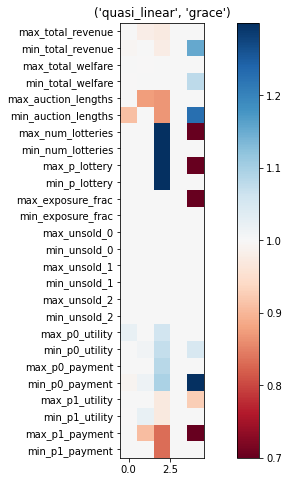

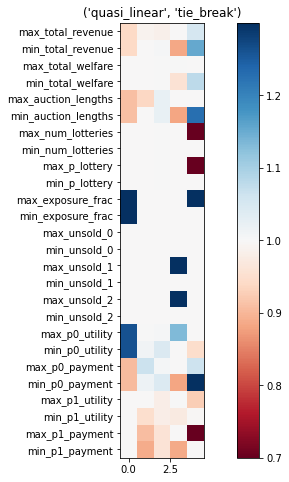

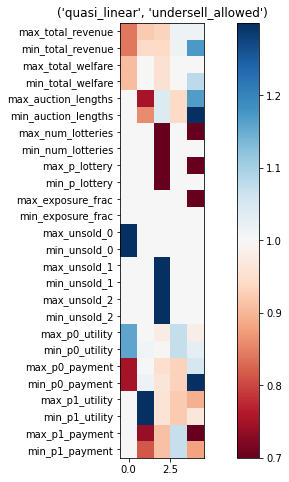

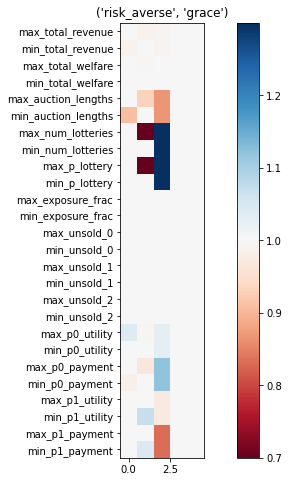

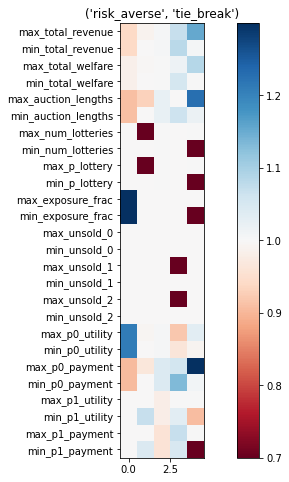

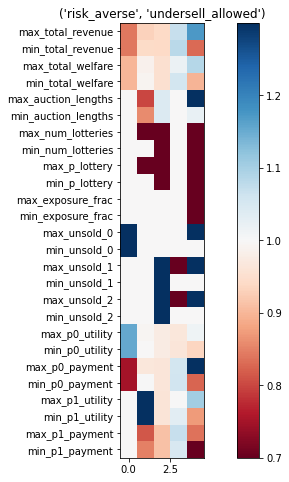

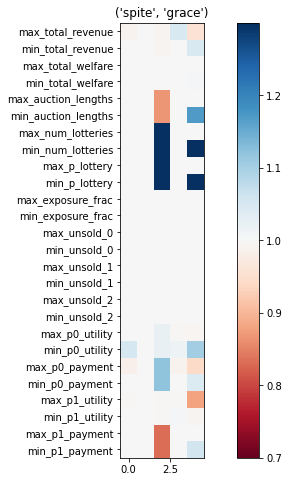

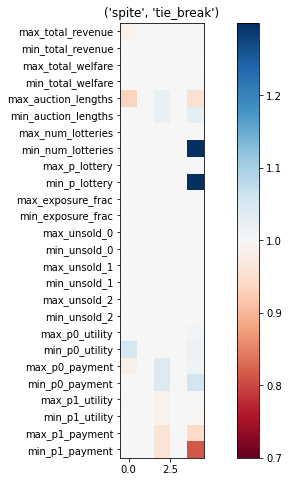

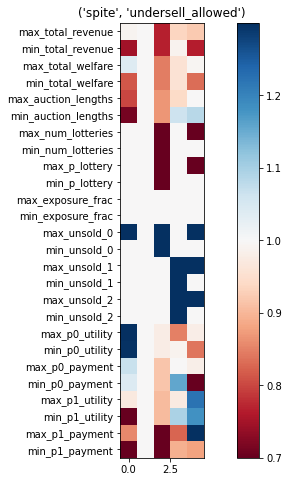

In [44]:
# 1) Get max/min for each valuation/treatment pairing over each stat

# First query down to relevant datapoints. Then groupby rule change and SATS =(game_name) and max/min?
metrics = ['total_revenue', 'total_welfare', 'auction_lengths', 'num_lotteries', 'p_lottery', 'exposure_frac', 'unsold_0', 'unsold_1', 'unsold_2']
for i in range(2): # TODO:
    metrics += [f'p{i}_utility', f'p{i}_payment']


df_plt_indexed = df_plt.set_index(['value_structure', 'rule']).sort_index().copy()

def make_data_dict(df):
    data = dict()
    for metric in metrics:
        data[f'max_{metric}'] = df.groupby('base_game_name')[metric].max()
        data[f'min_{metric}'] = df.groupby('base_game_name')[metric].min()
    return pd.DataFrame(data)
    
for idx, grp_df in df_plt.groupby(['value_structure', 'rule']):
    if idx[1] == 'base':
        continue
        
    try:
        data_grp_df = make_data_dict(grp_df)
        normalizer_grp_df = df_plt_indexed.loc[(idx[0], 'base')]
        data_normalized_df = make_data_dict(normalizer_grp_df)

        cmap_norm = plt.matplotlib.colors.TwoSlopeNorm(vmin=0.7, vcenter=1, vmax=1.3)
        cmap = plt.cm.get_cmap('RdBu').copy()
        cmap.set_bad('magenta')
        plt.figure(figsize=(12, 8))
        data = (data_grp_df / data_normalized_df).fillna(1).values.T # Fill NA b/c these values are often 0/0 for e.g. num_lotteries
        data[data == np.inf] = 10 # Inf should not show up as pink, but as a high number
        data[data == -np.inf] = 10 # Inf should not show up as pink, but as a high number
        plt.imshow(data, cmap=cmap, norm=cmap_norm)
        plt.title(idx)
        plt.yticks(range(len(data_grp_df.columns)), data_grp_df.columns)
        plt.colorbar()
        plt.show()
    except Exception as e:
        print(idx, e)

In [32]:
evals = Evaluation.objects.filter(checkpoint__equilibrium_solver_run__name='oct4_encumberedheuristic_oct4_encumberedheuristic_3_base_undersell_allowed-cfr_port_5_extexternal_plus-101')

In [33]:
for i, e in enumerate(evals):
    if e.checkpoint.t != 16251:
        continue
    if i == 38:
        a = analyze_samples(e.samples, e.checkpoint.equilibrium_solver_run.game.load_as_spiel())
    elif i == 39:
        m = analyze_samples(e.samples, e.checkpoint.equilibrium_solver_run.game.load_as_spiel())

In [34]:
name = 'oct4_encumberedheuristic_oct4_encumberedheuristic_3_base_undersell_allowed-cfr_port_7_extexternal_plus_full-101'
# name = 'oct4_encumberedheuristic_oct4_encumberedheuristic_4_spite_tie_break-cfr_port_7_extexternal_plus_full-101'
run = EquilibriumSolverRun.objects.get(name=name, experiment__name='oct13_external_heuristics_v1')

In [35]:
game, final_checkpoint, policy = get_results(run, load_policy=True)
evaluation = final_checkpoint.get_modal_eval()


In [36]:
retval = nash_conv(game, policy, return_only_nash_conv=False, restrict_to_heuristics=True)
print(retval)

_NashConvReturn(nash_conv=0.7031152257029305, player_improvements=array([0.35749558, 0.34561965]), br_policies=[<open_spiel.python.algorithms.best_response.BestResponsePolicy object at 0x7ff5e7e40490>, <open_spiel.python.algorithms.best_response.BestResponsePolicy object at 0x7ff5eac769d0>])


In [37]:
env_and_policy = make_env_and_policy(game, dict(final_checkpoint.equilibrium_solver_run.config))
for agent in env_and_policy.agents:
    agent.policy = policy
for player in range(game.num_players()):
    env_and_policy.agents[player] = ModalAgentDecorator(env_and_policy.agents[player])
modal_policy = env_and_policy.make_policy()
modal_retval = nash_conv(game, modal_policy, return_only_nash_conv=False, restrict_to_heuristics=True)
modal_retval

_NashConvReturn(nash_conv=17.431923076923077, player_improvements=array([17.43192308,  0.        ]), br_policies=[<open_spiel.python.algorithms.best_response.BestResponsePolicy object at 0x7ff51f4fc280>, <open_spiel.python.algorithms.best_response.BestResponsePolicy object at 0x7ff51f4fc310>])

In [47]:
# Policy captured from above

# Use the BR for p0 (where there is room for much improvement). What is going on with the visit count on this path?

def traverse(state, p0, p1):
    if state.is_terminal():
        # print(state)
        print("TERMINAL", state.returns()[0])
        return
    if state.is_chance_node():
        for action in state.legal_actions():
            traverse(state.child(action), p0, p1)
        return

    istring = state.information_state_string()
    # print(istring)
    try:
        info = policy._infostates[istring][2]
        print("Visits", info, "Player", state.current_player(), "Strategy Updates", policy._infostates[istring][1].sum().round(2))
    except KeyError:
        print("0 visits")
    
    
    print(policy(state))
    
    p = p0 if state.current_player() == 0 else modal_policy
    action_dist = p(state)
    
    print(action_dist)
    
    
    action = max(action_dist, key=action_dist.get) # modal
    # action = list(action_dist.keys())[0] # modal
    return traverse(state.child(action), p0, p1)


In [48]:
state = game.new_initial_state()
traverse(state, modal_retval.br_policies[0], modal_retval.br_policies[1])

Visits 10575 Player 0 Strategy Updates 5364.0
{0: 1.864280386727655e-10, 3: 0.9728701375001918, 7: 0.027129862313380014}
{3: 1}
Visits 21129 Player 1 Strategy Updates 15885.0
{0: 0.00020142419021640362, 7: 0.9997985758097836}
{0: 0.0, 7: 1.0}
Visits 10398 Player 0 Strategy Updates 5225.0
{0: 1.9138755973535402e-10, 3: 0.9999999998086124}
{3: 1}
Visits 7899 Player 1 Strategy Updates 5210.0
{0: 1.919385795439887e-10, 4: 0.4462583015901011, 7: 0.5537416982179605}
{0: 0.0, 4: 0.0, 7: 1.0}
Visits 6701 Player 0 Strategy Updates 5225.0
{0: 0.006315789662654242, 3: 0.9936842103373457}
{3: 1}
Visits 5641 Player 1 Strategy Updates 2952.0
{0: 3.387533871896138e-10, 4: 0.9999999993224933, 7: 3.387533871896138e-10}
{0: 0.0, 4: 1.0, 7: 0.0}
TERMINAL 59.92
Visits 10575 Player 0 Strategy Updates 5364.0
{0: 1.864280386727655e-10, 3: 0.9728701375001918, 7: 0.027129862313380014}
{3: 1}
Visits 20675 Player 1 Strategy Updates 15468.0
{0: 6.464966380954554e-05, 4: 0.01588988665642426, 7: 0.9840454636797662}

In [46]:
state = game.new_initial_state()
traverse(state, modal_policy, modal_retval.br_policies[1])

Visits 10575 Player 0 Strategy Updates 5364.0
Visits 21129 Player 1 Strategy Updates 15885.0
Visits 10398 Player 0 Strategy Updates 5225.0
Visits 7899 Player 1 Strategy Updates 5210.0
Visits 6701 Player 0 Strategy Updates 5225.0
Visits 5641 Player 1 Strategy Updates 2952.0
TERMINAL 59.92
Visits 10575 Player 0 Strategy Updates 5364.0
Visits 20675 Player 1 Strategy Updates 15468.0
Visits 10398 Player 0 Strategy Updates 5225.0
Visits 7672 Player 1 Strategy Updates 5136.0
TERMINAL 72.4
Visits 10327 Player 0 Strategy Updates 5087.0
Visits 21129 Player 1 Strategy Updates 15885.0
Visits 9561 Player 0 Strategy Updates 4367.0
Visits 10211 Player 1 Strategy Updates 8067.0
Visits 9398 Player 0 Strategy Updates 4340.0
Visits 9877 Player 1 Strategy Updates 7746.0
Visits 9316 Player 0 Strategy Updates 4316.0
Visits 9765 Player 1 Strategy Updates 7647.0
Visits 9237 Player 0 Strategy Updates 4296.0
Visits 9674 Player 1 Strategy Updates 7566.0
TERMINAL 34.60479999999997
Visits 10327 Player 0 Strategy U

In [22]:
Experiment.objects.all()

<QuerySet [<Experiment: oct12_external_heuristics_v1>, <Experiment: oct12_external_heuristics_v2>, <Experiment: oct12_external_heuristics_v3>, <Experiment: oct13_external_heuristics_v1>, <Experiment: oct16_external_full_v1>, <Experiment: oct13test>, <Experiment: oct16_deviations>]>

In [ ]:
Experiment.objects.filter(created__lte=timezone.now() - datetime.timedelta(days=5)).delete()

In [6]:
# for exp in list(Experiment.objects.all())[:-5]:
#     exp.delete()

jun8outcome
jun8ppo
neiltest_local
jun9ppo
jun9outcome
jun10outcome
jun10ppo
jun13outcome
jun13ppo
jun14ent
jun14ent_2
jun14ent_3
jun15external
jun16outcome
dqn
jun19outcome
jun21outcome
jun21external
jun22outcome
jun22external
jun23outcome
jun23external
jun23outcome_2
jun24_cfr_gamut_2
jun24_cfr_gamut_3
jun24_cfr_gamut_4
jun24_cfr_gamut_5
jun24_cfr_gamut_6
jun26_port
test_games
jun24_cfr_gamut_7
fdfasdfsadfsa_gamut_6
jun27_port
test
jun28_port
jun28_3percent
jul18
jul19
sep1
3players_sep1
contrast
sep19_encumbered
sep20_3Province
sep28_debug
sep28_encumbered
sep28_encumbered_v2
sep28v3
sep28v4
debugsep29
sep28v5
sep28v6
sep28v7
sep28v8
sep28v10
oct3_debug
oct03_v1
oct04_external_heuristics
oct04_debug
oct04_external_heuristics_v2
oct04_external_heuristics_v3
oct04_external_heuristics_v5
oct04_external_heuristics_v6
oct04_external_heuristics_v7
oct04_external_heuristics_v8
oct12_external_heuristics_v1
oct12_external_heuristics_v2
